In [1]:
import cv2
import pytesseract
import urllib
import numpy as np
from PIL import Image as im
import re
import imutils #added
import sys
import os
from scipy.ndimage import interpolation as inter

In [89]:
def rotate_image_180(image,angle):
    
    #rotate by small angle 
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    image = cv2.warpAffine(image, M=rot_mat, dsize=image.shape[1::-1], 
                          flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue = [255, 255, 255])
    
    #check if the docs needs to be rotated more than 180 degree
    #we have used pytesseract to find the rotation angle
    rot_data = pytesseract.image_to_osd(image);
    rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
    print(rot_data)
    angle = float(rot)
    print("Angle: {}".format(angle))
    if angle == 90.0:
        image = imutils.rotate_bound(image, angle)
        rot_data = pytesseract.image_to_osd(image);
        rot = re.search('(?<=Rotate: )\d+', rot_data).group(0)
        angle = float(rot)
        print("Angle2: {}".format(angle))
   
    img_rotated = imutils.rotate_bound(image, angle)#added
    
    b, g, r = cv2.split(img_rotated)
    rotated2 = cv2.merge([r, g, b])

    img = im.fromarray(rotated2)
    img.save('filename.jpg')
    return img

In [90]:
def small_angle(image):
    
    #In this method, we  convert image to black (absence of pixel) & white (presence of pixel).
    wd, ht = image.size
    pix = np.array(image.convert('1').getdata(), np.uint8)
    bin_img = 1 - (pix.reshape((ht, wd)) / 255.0)
    
    #image is projected vertically to get a histogram of pixels.
    def find_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score
    
    #Now the image is rotated at various angles (at a small interval of angles called Delta) 
    delta = 1
    limit = 5
    #image is rotated at various angles and above process is repeated
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    
    # the difference between the peaks will be calculated (Variance can also be used as one of the metrics).
    #The angle at which the maximum difference between peaks (or Variance) is found, 
    #that corresponding angle will be the Skew angle for the image.
    for angle in angles:
        hist, score = find_score(bin_img, angle)
        scores.append(score)
        
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: '+str(best_angle))

    return (best_angle)

Best angle: -1
Page number: 0
Orientation in degrees: 180
Rotate: 180
Orientation confidence: 3.98
Script: Latin
Script confidence: 4.51

Angle: 180.0


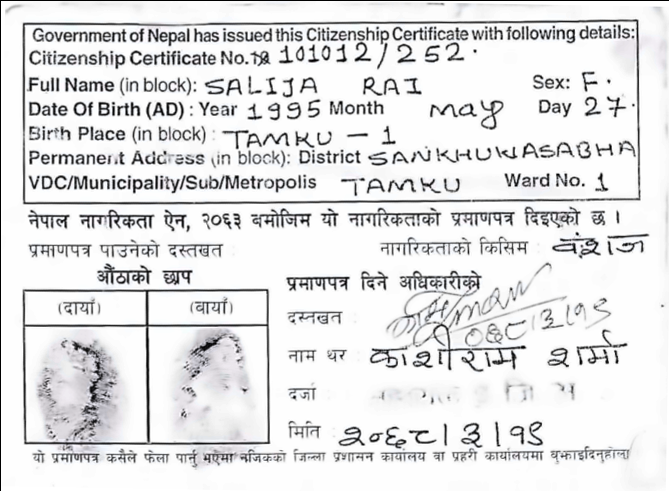

In [94]:
#import os
#filenames = next(os.walk("/home/ds/Documents/cit1/"))[2]
#for f in filenames:
    #path="/home/ds/Documents/cit1/"+str(f)
    ## bulk alignment process goes here

image = im.open("ct.png")
img=cv2.imread("ct.png")

#removing dots and random patches from images 
img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15) 

rot=small_angle(image)  #finding skew angle (learn about histogram equalization)
rotate_image_180(img,rot) 